## Hough / Retro-Hough Transformation

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import math
import random
import cv2
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy import stats 

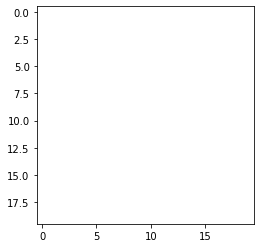

In [542]:
pixel = mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png");
plt.imshow(pixel)
plt.show()

This would be the empty template (20 pixels in height, 20 pixels wide) on which we can form our images!

In [679]:
sqrt=math.sqrt
pi=math.pi
alpha=0.785398
sigma=1
ybar=10
xbar=10
exp=math.exp
cos=math.cos
sin=math.sin
I0=2 #This can be set to be the SNR
SNR=I0

First we would consider the actual track without any noise and then proceed on to introducing noise later on...

In [680]:
for i in range(0,20):
    for j in range(0,20):
        intensity=I0*exp(-((((j-ybar))*cos(alpha))-(((i-xbar))*sin(alpha)))**2/(2*(sigma)**2))
        pixel[i,j]=(intensity,intensity,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


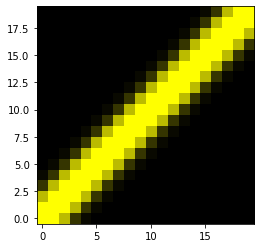

In [681]:
plt.imshow(pixel,origin='lower')
plt.show()

This represents the Gaussian power intensity profile of the track. No threshold has been set here. 

In [682]:
np.max(pixel)

2.0

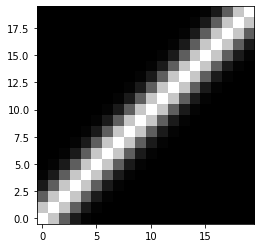

In [677]:
 #Convert color image to grayscale to help extraction of edges

pixel_gray=np.dot(pixel, [1,1,1])
plt.imshow(pixel_gray ,cmap = plt.get_cmap('gray'),origin='lower');

The image has been converted to Grayscale so that we dont have to deal with 3 labels (R,G,B) for each pixel.

In [678]:
np.max(pixel_gray)

4.0

In [691]:
binary_gray= mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png");
for i in range(0,20):
    for j in range(0,20):
        if(pixel_gray[i,j]>=(np.max(pixel_gray))/4):
            binary_gray[i,j]=(1,1,1)
        else:
            binary_gray[i,j]=(0,0,0)

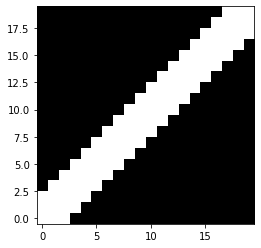

In [736]:
plt.imshow(binary_gray,origin='lower')
plt.show()

The above image is the Binary Spectrogram for the track, taking threshold as I0/4. Pixels having intensities above I0/4 are marked as 1 and others have been marked as 0. This should be close to 3 SDs from the mean.

Now introducing Gaussian noise to every pixel..

In [737]:
for i in range(0,20):
    for j in range(0,20):
        noise=np.random.normal(0,1)
        pixel_new[i,j]=abs((sqrt(SNR)*pixel_gray[i,j])+noise)

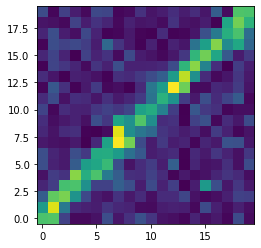

In [745]:
plt.imshow(pixel_new,origin='lower')
plt.show()

##### The above image represents the addition of noise with a Gaussian distribution to the original image.

Printing the max, min and avg intensities...

In [746]:
print("Maximum intensity:",np.max(pixel_new))
print("Average intensity:",np.mean(pixel_new))
print("Minimum intensity:",np. min(pixel_new))

Maximum intensity: 7.524507020568104
Average intensity: 1.4848386494015418
Minimum intensity: 0.0070160109624576306


Setting up the threshold to create a binary spectrogram...

In [747]:
th=np.max(pixel_gray)/4

Now creating a binary matrix based on the threshold..

In [748]:
pixel_new_binary=np.zeros(shape=(20,20))
for i in range(0,20):
    for j in range(0,20):
        if (pixel_new[i,j]>th):
            pixel_new_binary[i,j]=1

In [749]:
noisy_binary_img= mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png");
for i in range(0,20):
    for j in range(0,20):
        if (pixel_new_binary[i,j]==0):
            noisy_binary_img[i,j]=(0,0,0)

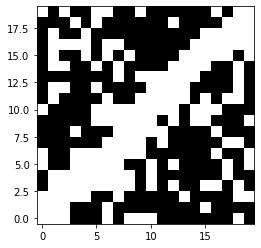

In [750]:
plt.imshow(noisy_binary_img,origin='lower')
plt.show()

##### This is what the binary image looks like after setting up the threshold. The Hough Transformation will work on this..

Now, we'll go forward with the Hough Transform...

In [751]:
count_coord=25
points_x=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
points_y=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
count=np.zeros(shape=(r_dim,theta_dim),dtype='int')

In [752]:
pixel_new_shape = pixel_new.shape

x_max = pixel_new_shape[0]
y_max = pixel_new_shape[1]

theta_max = 1.0 * math.pi 
theta_min = 0.0

r_min = 0.0
r_max = math.hypot(x_max, y_max)

r_dim = 200 
theta_dim = 300

hough_space = np.zeros((r_dim,theta_dim,))

for x in range(x_max):
    for y in range(y_max):
        if pixel_new_binary[x,y] == 0: continue
        for itheta in range(theta_dim):
            theta =1.0 *itheta * theta_max / theta_dim
            r = x * math.cos(theta) + y * math.sin(theta)
            ir = int(r_dim * ( 1.0 * r ) / r_max)
            
            
            points_x[ir,itheta,count[ir,itheta]]=x
            points_y[ir,itheta,count[ir,itheta]]=y
            
            count[ir,itheta]=count[ir,itheta]+1
            
            hough_space[ir,itheta] = hough_space[ir,itheta] + 1

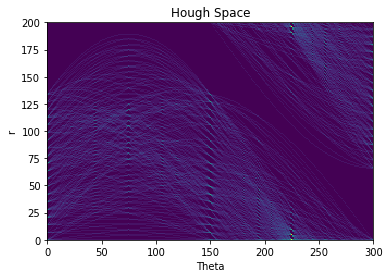

In [753]:
plt.imshow(hough_space,origin='lower')
plt.xlim(0,theta_dim)
plt.ylim(0,r_dim)
plt.xlabel('Theta')
plt.ylabel('r')
plt.title('Hough Space')
plt.show()

Each point on the Hough plane corresponds to a line in the cartesian plane. Each curve in the Hough plane corresponds to a family of lines passing through a fixed point. If 2 curves intersect, it would mean that 2 points in the Cartesian plane are joined by a common line. More the count, more the number of points on a common line. 

In [754]:
hough_space.shape

(200, 300)

Printing the max, min and avg counts of the Hough Space...

In [755]:
print("Maximum count:",np.max(hough_space))
print("Average count:",np.mean(hough_space))
print("Minimum count:",np.min(hough_space))

Maximum count: 20.0
Average count: 0.895
Minimum count: 0.0


We can now set a threshold for the Hough plane, that is, what is the minimum number of signal pixels on a line to classify it as a track.

In [795]:
th_hough=13.5

In [796]:
hough_space_binary_img= mpimg.imread(r"\Users\Kaustav Dutta\Desktop\hough_binary.png");
hough_space_binary=np.zeros(shape=(r_dim,theta_dim))
for i in range(hough_space.shape[0]):
    for j in range(hough_space.shape[1]):
        if hough_space[i,j]>th_hough:
            hough_space_binary_img[i,j]=(1,1,1)
            hough_space_binary[i,j]=1
        else:
            hough_space_binary_img[i,j]=(0,0,0)

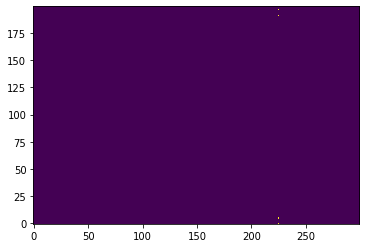

In [797]:
plt.imshow(hough_space_binary,origin='lower')
plt.show()

The above image represents the binary spectrogram for the Hough plane. Only those points are visible where the number of curves intersecting is >= threshold.

#### Retro-Transformation from Hough plane to familiar pixel plane

In [798]:
reverse_hough = mpimg.imread(r"\Users\Kaustav Dutta\Desktop\reverse_hough.png")

In [799]:
for r in range(hough_space.shape[0]):
    for theta in range(hough_space.shape[1]):
        if(hough_space_binary[r,theta]==1):
            for l in range(count[r,theta]):
                reverse_hough[points_x[r,theta,l],points_y[r,theta,l]]=(1,1,1)

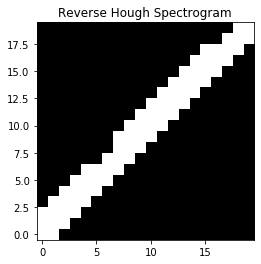

In [800]:
plt.imshow(reverse_hough,origin='lower')
plt.title('Reverse Hough Spectrogram')
plt.show()

These are the pixels which the Hough Algorithm recognises as track pixels.

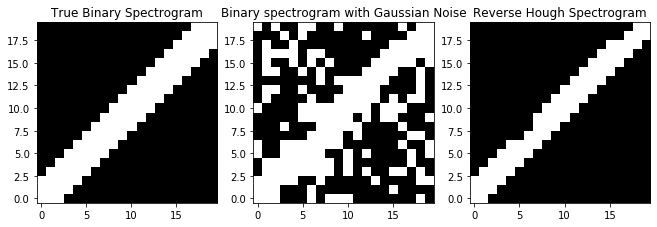

In [801]:
plt.figure(figsize=(11,11))
plt.subplot(131), plt.imshow(binary_gray,origin='lower'),plt.title('True Binary Spectrogram')
plt.subplot(132), plt.imshow(noisy_binary_img,origin='lower'),plt.title('Binary spectrogram with Gaussian Noise')
plt.subplot(133), plt.imshow(reverse_hough,origin='lower'),plt.title('Reverse Hough Spectrogram')
plt.show()